Using device: cpu
Epoch 1/23: Train Loss: 2.1145, Test Loss: 1.6745, Train Err: 68.59%, Test Err: 46.09%
Epoch 2/23: Train Loss: 1.2317, Test Loss: 0.8681, Train Err: 35.50%, Test Err: 24.02%
Epoch 3/23: Train Loss: 0.7380, Test Loss: 0.5753, Train Err: 20.41%, Test Err: 14.70%
Epoch 4/23: Train Loss: 0.5401, Test Loss: 0.4532, Train Err: 14.79%, Test Err: 12.21%
Epoch 5/23: Train Loss: 0.4401, Test Loss: 0.3682, Train Err: 12.52%, Test Err: 10.56%
Epoch 6/23: Train Loss: 0.3826, Test Loss: 0.3385, Train Err: 10.89%, Test Err: 10.21%
Epoch 7/23: Train Loss: 0.3318, Test Loss: 0.2903, Train Err: 9.41%, Test Err: 8.12%
Epoch 8/23: Train Loss: 0.2877, Test Loss: 0.2509, Train Err: 8.24%, Test Err: 7.13%
Epoch 9/23: Train Loss: 0.2536, Test Loss: 0.2251, Train Err: 7.56%, Test Err: 6.53%
Epoch 10/23: Train Loss: 0.2363, Test Loss: 0.1887, Train Err: 6.95%, Test Err: 5.18%
Epoch 11/23: Train Loss: 0.1997, Test Loss: 0.1801, Train Err: 5.68%, Test Err: 5.43%
Epoch 12/23: Train Loss: 0.1904, 

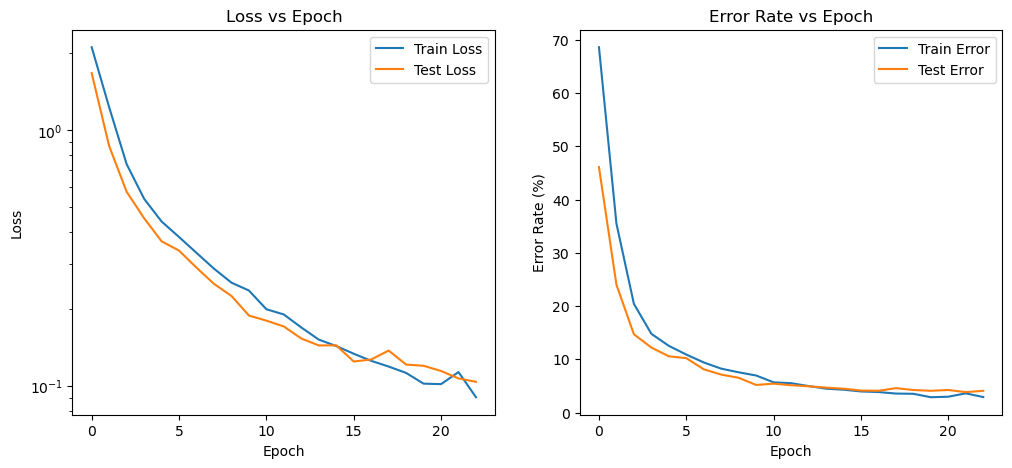


Final Results:
Train Accuracy: 97.93% (7140/7291)
Test Accuracy: 95.91% (1925/2007)


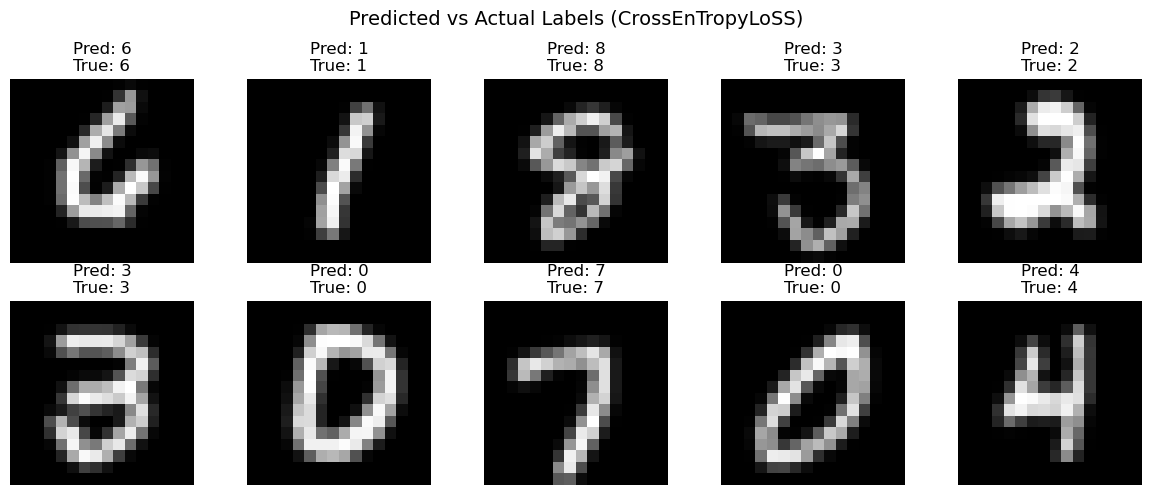

In [1]:
#Version 1 of LuCun Replica

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

# Set random seeds
torch.manual_seed(1337)
np.random.seed(1337)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Step 1: Data Preparation with 16x16 resized MNIST
def get_dataloader(split='train', batch_size=64, return_subset=False):
    full_dataset = datasets.MNIST(
        './data', train=(split == 'train'), download=True,
        transform=transforms.Compose([
            transforms.Resize((16, 16), interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
    )
    n_samples = 7291 if split == 'train' else 2007
    indices = np.random.permutation(len(full_dataset))[:n_samples]
    subset = Subset(full_dataset, indices)
    loader = DataLoader(subset, batch_size=batch_size, shuffle=True)
    
    if return_subset:
        return loader, subset
    else:
        return loader

train_loader = get_dataloader('train', batch_size=64)
test_loader, test_subset = get_dataloader('test', batch_size=64, return_subset=True)

# Step 2: Define LeCun1989 Network (Conv + Pool + FC)
class LeCun1989Net(nn.Module):
    def __init__(self):
        super(LeCun1989Net, self).__init__()
        # Conv1: 12 filters, 5x5 → 12x12x12 → pool → 12x6x6
        self.conv1 = nn.Conv2d(1, 12, kernel_size=5, stride=1)
        self.pool1 = nn.AvgPool2d(kernel_size=2)

        # Conv2: 12 filters, 5x5 → 12x2x2 → pool → 12x1x1
        self.conv2 = nn.Conv2d(12, 12, kernel_size=5, stride=1)
        self.pool2 = nn.AvgPool2d(kernel_size=2)

        # FC: 12*1*1 → 30 → 10
        self.fc1 = nn.Linear(12 * 1 * 1, 30)
        self.fc2 = nn.Linear(30, 10)

    def forward(self, x):
        x = torch.tanh(self.conv1(x))  # [B, 12, 12, 12]
        x = self.pool1(x)              # [B, 12, 6, 6]
        x = torch.tanh(self.conv2(x))  # [B, 12, 2, 2]
        x = self.pool2(x)              # [B, 12, 1, 1]
        x = x.view(x.size(0), -1)      # [B, 12]
        x = torch.tanh(self.fc1(x))    # [B, 30]
        x = self.fc2(x)                # [B, 10]
        return x

# Initialize model
model = LeCun1989Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Step 3: Training Function
def train_model(model, train_loader, test_loader, epochs=23):
    train_losses, test_losses = [], []
    train_errs, test_errs = [], []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * labels.size(0)
            correct += (outputs.argmax(dim=1) == labels).sum().item()
            total += labels.size(0)

        train_loss = epoch_loss / total
        train_error = 100 * (1 - correct / total)

        # Test Evaluation
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            test_loss = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * labels.size(0)
                correct += (outputs.argmax(dim=1) == labels).sum().item()
                total += labels.size(0)

            test_loss /= total
            test_error = 100 * (1 - correct / total)

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_errs.append(train_error)
        test_errs.append(test_error)

        print(f"Epoch {epoch+1}/{epochs}: "
              f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, "
              f"Train Err: {train_error:.2f}%, Test Err: {test_error:.2f}%")

    return train_losses, test_losses, train_errs, test_errs

# Step 4: Train the model
train_losses, test_losses, train_errs, test_errs = train_model(model, train_loader, test_loader)

# Step 5: Plot Learning Curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epoch')

plt.subplot(1, 2, 2)
plt.plot(train_errs, label='Train Error')
plt.plot(test_errs, label='Test Error')
plt.xlabel('Epoch')
plt.ylabel('Error Rate (%)')
plt.legend()
plt.title('Error Rate vs Epoch')

plt.show()

# Step 6: Final Evaluation
model.eval()
with torch.no_grad():
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        correct_train += (outputs.argmax(dim=1) == labels).sum().item()
        total_train += labels.size(0)

    correct_test = 0
    total_test = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        correct_test += (outputs.argmax(dim=1) == labels).sum().item()
        total_test += labels.size(0)

    print(f"\nFinal Results:")
    print(f"Train Accuracy: {correct_train / total_train * 100:.2f}% ({correct_train}/{total_train})")
    print(f"Test Accuracy: {correct_test / total_test * 100:.2f}% ({correct_test}/{total_test})")

# Visualization: Show some predictions
import random
model.eval()
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
sample_indices = random.sample(range(len(test_subset)), 10)

for i, ax in enumerate(axs.flat):
    image, label = test_subset[sample_indices[i]]
    image_input = image.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image_input)
        pred = output.argmax(dim=1).item()
    ax.imshow(image.squeeze().cpu(), cmap='gray')
    ax.set_title(f"Pred: {pred}\nTrue: {label}")
    ax.axis('off')

plt.suptitle("Predicted vs Actual Labels (CrossEnTropyLoSS)", fontsize=14)
plt.tight_layout()
plt.show()